In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, kendalltau
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def rank_features(df_sub, importance_cols, agg="mean"):
    
    if agg == "mean":
        agg_vals = df_sub[importance_cols].abs().mean(axis=0)
    elif agg == "median":
        agg_vals = df_sub[importance_cols].abs().median(axis=0)
    else:
        raise ValueError("agg must be 'mean' or 'median'")

    return agg_vals.rank(ascending=False, method="average")

In [3]:
def top_k_overlap(ranks_a, ranks_b, k=5):
    top_a = set(ranks_a[ranks_a <= k].index)
    top_b = set(ranks_b[ranks_b <= k].index)
    return len(top_a & top_b) / k

In [4]:
def compute_disagreement_single(df, dataset_id, model, importance_cols, k=5 ):
    """
    Computes SHAP vs LIME, SHAP vs IG, LIME vs IG
    for one dataset + one model
    """
    df_sub = df[df["model"] == model]

    explainers = df_sub["explainer"].unique()
    results = []

    for exp_a, exp_b in combinations(explainers, 2):
        df_a = df_sub[df_sub["explainer"] == exp_a]
        df_b = df_sub[df_sub["explainer"] == exp_b]

        ranks_a = rank_features(df_a, importance_cols)
        ranks_b = rank_features(df_b, importance_cols)

        # Align features
        common_features = ranks_a.index.intersection(ranks_b.index)
        r_a = ranks_a.loc[common_features]
        r_b = ranks_b.loc[common_features]

        spearman = spearmanr(r_a, r_b).correlation
        kendall = kendalltau(r_a, r_b).correlation
        overlap = top_k_overlap(r_a, r_b, k=k)

        results.append({
            "dataset_id": dataset_id,
            "model": model,
            "comparison": f"{exp_a} vs {exp_b}",
            "spearman": spearman,
            "kendall_tau": kendall,
            "top_k_overlap": overlap
        })

    return pd.DataFrame(results)


In [5]:
def create_dataset(dataset_id):
    df_IG = pd.read_csv(f"results/IG_{dataset_id}.csv")
    features= df_IG.columns[1:].tolist()
    df_IG["model"] = "mlp"
    df_IG["explainer"] = "IG"
    df_SHAP_LIME = pd.read_csv(f"results/SHAP_LIME_{dataset_id}.csv")
    dfs = [df_SHAP_LIME, df_IG]
    df = pd.concat(dfs, ignore_index=True)

    return df, features

In [6]:
datasets= [1504, 1590, 1510, 37, 31, 59, 45547, 44, 1558, 40981]
models= ['lr', 'rf', 'mlp']

In [7]:
all_results = []

for dataset_id in datasets:

    df, colname = create_dataset(dataset_id=dataset_id)

    for model in models:
        res = compute_disagreement_single(
            df,
            dataset_id=dataset_id,
            model=model,
            k=5,
            importance_cols=colname
        )
        all_results.append(res)

disagreement_df = pd.concat(all_results, ignore_index=True)


In [8]:
disagreement_df

,dataset_id,model,comparison,spearman,kendall_tau,top_k_overlap
0,1504,lr,shap vs lime,0.714980,0.620056,1.0
1,1504,rf,shap vs lime,0.472259,0.356061,1.0
2,1504,mlp,shap vs lime,0.499206,0.384834,1.0
3,1504,mlp,shap vs IG,0.515417,0.384834,1.0
4,1504,mlp,lime vs IG,0.895388,0.757576,1.0
5,1590,lr,shap vs lime,0.802198,0.692308,1.0
6,1590,rf,shap vs lime,0.556044,0.516484,0.6
7,1590,mlp,shap vs lime,-0.252747,-0.164835,0.0
8,1590,mlp,shap vs IG,0.032967,0.032967,0.4
9,1590,mlp,lime vs IG,0.639560,0.494505,0.6


In [9]:
per_dataset = (
    disagreement_df
    .groupby("dataset_id")[["spearman", "kendall_tau", "top_k_overlap"]]
    .mean()
    .reset_index()
)

per_dataset

,dataset_id,spearman,kendall_tau,top_k_overlap
0,31,0.248976,0.206916,0.48
1,37,0.923810,0.842857,0.92
2,44,0.678841,0.506577,0.72
3,59,0.846429,0.716968,0.80
4,1504,0.619450,0.500672,1.00
5,1510,0.910118,0.767493,0.72
6,1558,0.411765,0.380000,0.56
7,1590,0.355604,0.314286,0.52
8,40981,0.458462,0.371429,0.56
9,45547,0.623636,0.534545,0.84


In [10]:
per_model = (
    disagreement_df
    .groupby("model")[["spearman", "kendall_tau", "top_k_overlap"]]
    .mean()
    .reset_index()
)
per_model

,model,spearman,kendall_tau,top_k_overlap
0,lr,0.845187,0.756595,0.920000
1,mlp,0.484010,0.396933,0.606667
2,rf,0.741330,0.623478,0.820000


In [11]:
overall = disagreement_df[["spearman", "kendall_tau", "top_k_overlap"]].mean()
overall

spearman         0.607709
kendall_tau      0.514174
top_k_overlap    0.712000
dtype: float64

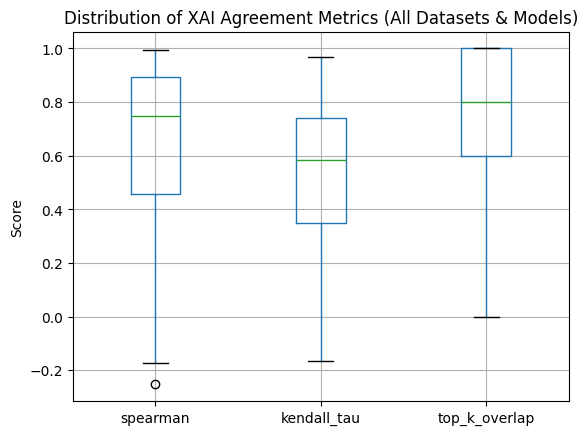

In [12]:
metrics = ["spearman", "kendall_tau", "top_k_overlap"]

plt.figure()
disagreement_df[metrics].boxplot()
plt.ylabel("Score")
plt.title("Distribution of XAI Agreement Metrics (All Datasets & Models)")
plt.show()

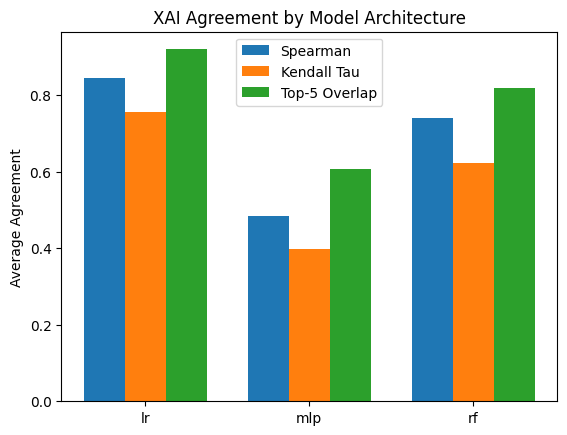

In [13]:
plt.figure()
x = np.arange(len(per_model["model"]))
width = 0.25

plt.bar(x - width, per_model["spearman"], width, label="Spearman")
plt.bar(x, per_model["kendall_tau"], width, label="Kendall Tau")
plt.bar(x + width, per_model["top_k_overlap"], width, label="Top-5 Overlap")

plt.xticks(x, per_model["model"])
plt.ylabel("Average Agreement")
plt.title("XAI Agreement by Model Architecture")
plt.legend()
plt.show()

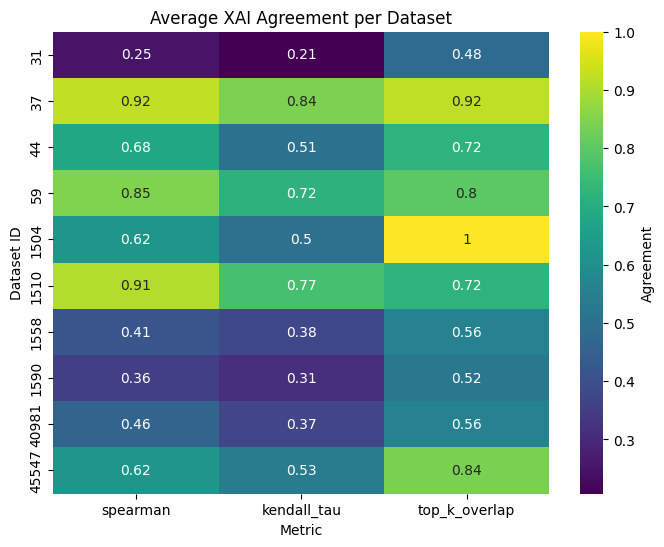

In [14]:
heatmap_data = per_dataset.set_index("dataset_id")

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="viridis",
    cbar_kws={"label": "Agreement"}
)
plt.title("Average XAI Agreement per Dataset")
plt.xlabel("Metric")
plt.ylabel("Dataset ID")
plt.show()

In [15]:
names={
    31: "credit-g",
    37: "diabetes",
    44: "spambase",
    59: "ionosphere",
    1504: "Steel-Plates-Fault",
    1510: "Breast Cancer",
    1558: "bank-marketing",
    1590: "Adult",
    40981: "Australian",
    45547: "Cardiovascular-Disease-dataset"
}

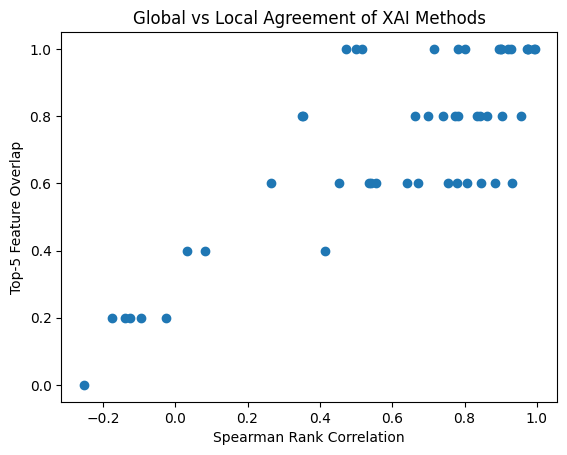

In [16]:
plt.figure()
plt.scatter(
    disagreement_df["spearman"],
    disagreement_df["top_k_overlap"]
)
plt.xlabel("Spearman Rank Correlation")
plt.ylabel("Top-5 Feature Overlap")
plt.title("Global vs Local Agreement of XAI Methods")
plt.show()

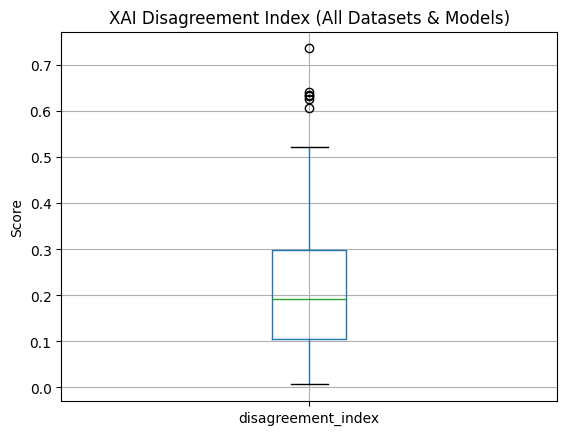

In [23]:
disagreement_df["disagreement_index"] = (
    (1 - (disagreement_df["spearman"] + 1) / 2)
  + (1 - (disagreement_df["kendall_tau"] + 1) / 2)
  + (1 - disagreement_df["top_k_overlap"])
) / 3

plt.figure()
disagreement_df[["disagreement_index"]].boxplot()
plt.ylabel("Score")
plt.title("XAI Disagreement Index (All Datasets & Models)")
plt.show()